In [1]:
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd

In [2]:
from src.paychex_ml.external_data import get_bls_data
from src.paychex_ml.external_data import get_census_data
from src.paychex_ml.external_data import get_external_data

# Data

## BLS

In [3]:
seriesid = ["LNS14000000", "CEU0000000001", "CES0000000001"]

In [4]:
df = get_bls_data(seriesid)

Processing:  LNS14000000
Processing:  CEU0000000001
Processing:  CES0000000001


In [5]:
df = df.set_index(pd.DatetimeIndex(df['date'])).drop(columns='date')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87 entries, 2022-03-01 to 2015-01-01
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UnemploymentRate  87 non-null     float64
 1   NFPayrolls_nsa    87 non-null     float64
 2   NFPayrolls_sa     87 non-null     float64
dtypes: float64(3)
memory usage: 2.7 KB


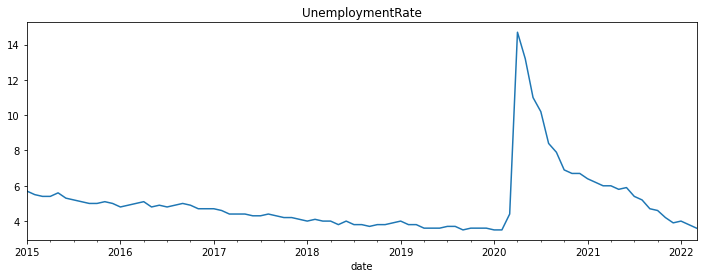

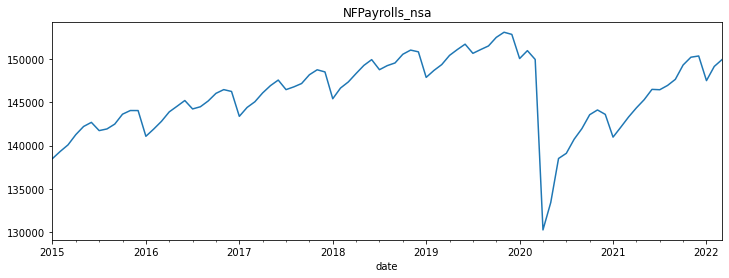

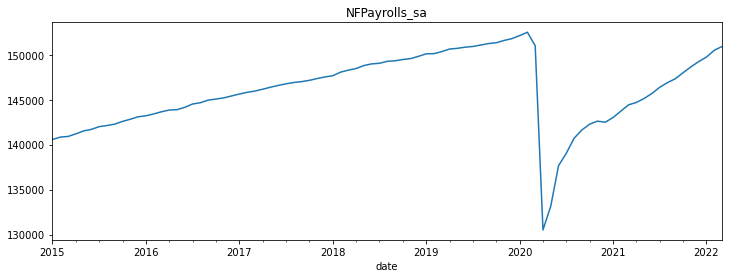

In [7]:
for c in df.columns:
    fig, ax = plt.subplots(figsize=(12,4))
    df[c].plot(ax = ax)
    plt.title(c)

## Census

In [8]:
__name__

'__main__'

In [69]:
headers = {'Content-type': 'application/json'}
data = json.dumps({"category_code": 'TOTAL'})
p = requests.get('http://api.census.gov/data/timeseries/eits/bfs?get=cell_value,time_slot_id&category_code=TOTAL&seasonally_adj&data_type_code=BA_BA&for=US&time=from+2015',
                  data=data)

In [71]:
p = json.loads(p.text)

In [72]:
p

[['cell_value',
  'time_slot_id',
  'category_code',
  'seasonally_adj',
  'data_type_code',
  'time',
  'us'],
 ['258765', '781', 'TOTAL', 'no', 'BA_BA', '2015-01', '1'],
 ['256949', '781', 'TOTAL', 'yes', 'BA_BA', '2015-01', '1'],
 ['244207', '782', 'TOTAL', 'no', 'BA_BA', '2015-02', '1'],
 ['229473', '782', 'TOTAL', 'yes', 'BA_BA', '2015-02', '1'],
 ['249226', '783', 'TOTAL', 'no', 'BA_BA', '2015-03', '1'],
 ['229317', '783', 'TOTAL', 'yes', 'BA_BA', '2015-03', '1'],
 ['296477', '784', 'TOTAL', 'no', 'BA_BA', '2015-04', '1'],
 ['231164', '784', 'TOTAL', 'yes', 'BA_BA', '2015-04', '1'],
 ['212198', '785', 'TOTAL', 'no', 'BA_BA', '2015-05', '1'],
 ['224660', '785', 'TOTAL', 'yes', 'BA_BA', '2015-05', '1'],
 ['217123', '786', 'TOTAL', 'no', 'BA_BA', '2015-06', '1'],
 ['233832', '786', 'TOTAL', 'yes', 'BA_BA', '2015-06', '1'],
 ['255280', '787', 'TOTAL', 'no', 'BA_BA', '2015-07', '1'],
 ['237200', '787', 'TOTAL', 'yes', 'BA_BA', '2015-07', '1'],
 ['208495', '788', 'TOTAL', 'no', 'BA_BA'

In [93]:
df = pd.DataFrame(p)
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df['date'] = pd.to_datetime(df['time'] + '01', format="%Y-%m%d").dt.strftime("%Y%m%d")
df = df.drop(['time_slot_id','category_code','data_type_code','time','us'], axis=1).set_index(['date','seasonally_adj']).unstack(1)['cell_value'].rename(columns={'no': 'BusinessFormationStats_nsa', 'yes': 'BusinessFormationStats_sa'})

In [106]:
df

seasonally_adj,BusinessFormationStats_nsa,BusinessFormationStats_sa
date,,
20150101,258765,256949
20150201,244207,229473
20150301,249226,229317
20150401,296477,231164
20150501,212198,224660
...,...,...
20211001,363578,431427
20211101,333958,431017
20211201,372825,418884


## FRED

In [262]:
series_dict = {
    'Nation Income & Expenditures': ['GDPC1', 'GDPPOT', 'W875RX1', 'PCEC96', 'PSAVERT', 'FYFR', 'FYONET', 'FYFSD','GFDEBTN'],
    'Pop Employment Labor': ['PAYEMS', 'UNRATE', 'ICSA', 'UEMPMEAN', 'JTSJOL', 'AWHMAN', 'AHETPI', 'OPHNFB', 'POP', 'CLF16OV',
                             'CIVPART'],
    'Prod & Bus Act': ['INDPRO', 'TCU', 'BUSINV', 'RRSFS', 'ALTSALES', 'DGORDER', 'BUSLOANS', 'TOTALSL', 'CP', 'HOUST', 'PERMIT',
                       'UNDCONTSA'],
    'Prices': ['CPIAUCSL', 'PCEPI', 'PCEPILFE', 'GDPDEF', 'PPIFIS', 'WPSFD49207', 'WPSFD4131', 'WPSID62', 'USSTHPI', 'SPCS20RSA',
               'DCOILWTICO', 'GASREGW', 'MHHNGSP'],
    'Money Bank Finance': ['BOGMBASE', 'M1SL', 'M2SL', 'SP500', 'DJIA', 'WILL5000IND', 'VIXCLS', 'STLFSI2', 'BAMLCC0A2AATRIV', 'FF', 'WGS3MO', 'WGS1YR', 'WGS5YR', 'WFII5', 'WGS10YR', 'WFII10', 'WAAA', 'WBAA', 'MORTGAGE15US', 'MORTGAGE30US', 'DEXUSEU', 'DEXCHUS', 'DEXCAUS']

}

In [263]:
import requests, json
import pandas as pd

In [93]:
from openpyxl import load_workbook
import numpy as np

In [235]:
total_df = []
for k in series_dict:
    series_df = []
    print(k)
    for s in series_dict[k]:
        print(s)
        url = 'https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type=json'\
            .format(s,"2f07bf8c1db37581bdb4874f8fa68418")
        p = requests.get(url)
        json_response = json.loads(p.text)
        df = pd.DataFrame(json_response['observations'])\
            .rename(columns={'value': s})\
            .drop(columns=['realtime_start', 'realtime_end'])

        df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")

        df = df.set_index('date')\
            .replace(".", np.nan)\
            .astype(float)

        idx = pd.date_range(df[~pd.isna(df)].index.min(), df[~pd.isna(df)].index.max(), freq='MS')
        df = df.reindex(idx, method='ffill').fillna(method='ffill')
        df = df[df.index>= '2010-01-01']

        series_df.append(df)

    df_cat = pd.concat(series_df, axis=1)
    df_cat = df_cat.reset_index().rename(columns={'index': 'date'})
    df_cat['date'] = df_cat['date'].apply(lambda x: x.strftime('%Y%m%d'))
    #df.to_excel("externa_data.xlsx", sheet_name=k)
    path = "external_data.xlsx"
    book = load_workbook(path)
    writer = pd.ExcelWriter(path, engine = 'openpyxl')
    writer.book = book
    df_cat.to_excel(writer, sheet_name = k, index=False)
    writer.save()
    writer.close()
    total_df.append(df_cat.set_index('date'))

Nation Income & Expenditures
GDPC1


KeyError: 'seriess'

In [237]:
json_response

{'realtime_start': '2022-04-15',
 'realtime_end': '2022-04-15',
 'observation_start': '1600-01-01',
 'observation_end': '9999-12-31',
 'units': 'lin',
 'output_type': 1,
 'file_type': 'json',
 'order_by': 'observation_date',
 'sort_order': 'asc',
 'count': 300,
 'offset': 0,
 'limit': 100000,
 'observations': [{'realtime_start': '2022-04-15',
   'realtime_end': '2022-04-15',
   'date': '1947-01-01',
   'value': '2034.45'},
  {'realtime_start': '2022-04-15',
   'realtime_end': '2022-04-15',
   'date': '1947-04-01',
   'value': '2029.024'},
  {'realtime_start': '2022-04-15',
   'realtime_end': '2022-04-15',
   'date': '1947-07-01',
   'value': '2024.834'},
  {'realtime_start': '2022-04-15',
   'realtime_end': '2022-04-15',
   'date': '1947-10-01',
   'value': '2056.508'},
  {'realtime_start': '2022-04-15',
   'realtime_end': '2022-04-15',
   'date': '1948-01-01',
   'value': '2087.442'},
  {'realtime_start': '2022-04-15',
   'realtime_end': '2022-04-15',
   'date': '1948-04-01',
   'valu

In [206]:
df = pd.concat(total_df, axis=1, keys=series_dict.keys())

In [207]:
df

Nation Income & Expenditures                                         \
                                GDPC1       GDPPOT  W875RX1   PCEC96 PSAVERT   
20100101                    15456.059  16173.80434  10490.7  10547.0     5.9   
20100201                    15456.059  16173.80434  10487.0  10586.5     5.6   
20100301                    15456.059  16173.80434  10529.1  10637.1     5.6   
20100401                    15605.628  16227.23434  10638.7  10658.8     6.2   
20100501                    15605.628  16227.23434  10740.6  10685.3     6.7   
...                               ...          ...      ...      ...     ...   
20310601                          NaN  23622.05000      NaN      NaN     NaN   
20310701                          NaN  23721.65000      NaN      NaN     NaN   
20310801                          NaN  23721.65000      NaN      NaN     NaN   
20310901                          NaN  23721.65000      NaN      NaN     NaN   
20311001                          NaN  23821.31000      NaN      NaN     NaN   

                                                      Pop Employment Labor  \
               FYFR     FYONET      FYFSD     GFDEBTN               PAYEMS   
20100101  2104989.0  3517677.0 -1412688.0  12773123.0             129790.0   
20100201  2104989.0  3517677.0 -1412688.0  12773123.0             129698.0   
20100301  2104989.0  3517677.0 -1412688.0  12773123.0             129879.0   
20100401  2104989.0  3517677.0 -1412688.0  13201792.0             130110.0   
20100501  2104989.0  3517677.0 -1412688.0  13201792.0             130650.0   
...             ...        ...        ...         ...                  ...   
20310601        NaN        NaN        NaN         NaN                  NaN   
20310701        NaN        NaN        NaN         NaN                  NaN   
20310801        NaN        NaN        NaN         NaN                  NaN   
20310901        NaN        NaN        NaN         NaN                  NaN   
20311001        NaN        NaN        NaN         NaN                  NaN   

          ... Money Bank Finance                                          \
          ...              WFII5 WGS10YR WFII10  WAAA  WBAA MORTGAGE15US   
20100101  ...               0.53    3.83   1.47  5.34  6.41         4.54   
20100201  ...               0.44    3.66   1.33  5.28  6.23         4.39   
20100301  ...               0.50    3.69   1.51  5.31  6.33         4.40   
20100401  ...               0.70    3.79   1.57  5.30  6.28         4.39   
20100501  ...               0.49    3.76   1.37  5.20  6.14         4.39   
...       ...                ...     ...    ...   ...   ...          ...   
20310601  ...                NaN     NaN    NaN   NaN   NaN          NaN   
20310701  ...                NaN     NaN    NaN   NaN   NaN          NaN   
20310801  ...                NaN     NaN    NaN   NaN   NaN          NaN   
20310901  ...                NaN     NaN    NaN   NaN   NaN          NaN   
20311001  ...                NaN     NaN    NaN   NaN   NaN          NaN   

                                               
         MORTGAGE30US DEXUSEU DEXCHUS DEXCAUS  
20100101         5.14  1.5100  6.8270  1.0430  
20100201         4.98  1.3904  6.8260  1.0651  
20100301         5.05  1.3516  6.8263  1.0421  
20100401         5.08  1.3569  6.8263  1.0073  
20100501         5.06  1.3302  6.8247  1.0112  
...               ...     ...     ...     ...  
20310601          NaN     NaN     NaN     NaN  
20310701          NaN     NaN     NaN     NaN  
20310801          NaN     NaN     NaN     NaN  
20310901          NaN     NaN     NaN     NaN  
20311001          NaN     NaN     NaN     NaN  

[262 rows x 68 columns]

In [209]:
from azure.storage.blob import BlobServiceClient
from src.paychex_ml.utils import load_credentials
from src.paychex_ml.utils import upload_df_parquet

In [211]:
credentials = load_credentials("blob_storage",
                               file="C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/credentials.yml")

# Start client
blob_service_client = BlobServiceClient.from_connection_string(credentials['conn_string'])

# Upload data

blob_client = upload_df_parquet(df, "external_data_fred.parquet", blob_service_client, container='external-data')

Uploaded external_data_fred.parquet


#### Dictionary

In [274]:
dictionary = []
for k in series_dict:
    print(k)
    for s in series_dict[k]:
        print(s)
        url = 'https://api.stlouisfed.org/fred/series?series_id={}&api_key={}&file_type=json'\
            .format(s,"2f07bf8c1db37581bdb4874f8fa68418")
        p = requests.get(url)
        json_response = json.loads(p.text)
        df = pd.DataFrame(json_response['seriess'])
        dictionary.append(df)

Nation Income & Expenditures
GDPC1
GDPPOT
W875RX1
PCEC96
PSAVERT
FYFR
FYONET
FYFSD
GFDEBTN
Pop Employment Labor
PAYEMS
UNRATE
ICSA
UEMPMEAN
JTSJOL
AWHMAN
AHETPI
OPHNFB
POP
CLF16OV
CIVPART
Prod & Bus Act
INDPRO
TCU
BUSINV
RRSFS
ALTSALES
DGORDER
BUSLOANS
TOTALSL
CP
HOUST
PERMIT
UNDCONTSA
Prices
CPIAUCSL
PCEPI
PCEPILFE
GDPDEF
PPIFIS
WPSFD49207
WPSFD4131
WPSID62
USSTHPI
SPCS20RSA
DCOILWTICO
GASREGW
MHHNGSP
Money Bank Finance
BOGMBASE
M1SL
M2SL
SP500
DJIA
WILL5000IND
VIXCLS
STLFSI2
BAMLCC0A2AATRIV
FF
WGS3MO
WGS1YR
WGS5YR
WFII5
WGS10YR
WFII10
WAAA
WBAA
MORTGAGE15US
MORTGAGE30US
DEXUSEU
DEXCHUS
DEXCAUS


In [275]:
pd.concat(dictionary)#.to_excel('DictionaryFRED.xlsx')

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
0,GDPC1,2022-04-15,2022-04-15,Real Gross Domestic Product,1947-01-01,2021-10-01,Quarterly,Q,Billions of Chained 2012 Dollars,Bil. of Chn. 2012 $,Seasonally Adjusted Annual Rate,SAAR,2022-03-30 07:56:03-05,90,BEA Account Code: A191RX\n\nReal gross domesti...
0,GDPPOT,2022-04-15,2022-04-15,Real Potential Gross Domestic Product,1949-01-01,2031-10-01,Quarterly,Q,Billions of Chained 2012 Dollars,Bil. of Chn. 2012 $,Not Seasonally Adjusted,NSA,2021-07-01 17:45:02-05,71,Real potential GDP is the CBO’s estimate of th...
0,W875RX1,2022-04-15,2022-04-15,Real personal income excluding current transfe...,1959-01-01,2022-02-01,Monthly,M,Billions of Chained 2012 Dollars,Bil. of Chn. 2012 $,Seasonally Adjusted Annual Rate,SAAR,2022-03-31 07:43:31-05,46,BEA Account Code: W875RX\nA Guide to the Natio...
0,PCEC96,2022-04-15,2022-04-15,Real Personal Consumption Expenditures,2002-01-01,2022-02-01,Monthly,M,Billions of Chained 2012 Dollars,Bil. of Chn. 2012 $,Seasonally Adjusted Annual Rate,SAAR,2022-03-31 07:43:15-05,72,BEA Account Code: DPCERX\nA Guide to the Natio...
0,PSAVERT,2022-04-15,2022-04-15,Personal Saving Rate,1959-01-01,2022-02-01,Monthly,M,Percent,%,Seasonally Adjusted Annual Rate,SAAR,2022-03-31 07:43:02-05,81,BEA Account Code: A072RC\nPersonal saving as a...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MORTGAGE15US,2022-04-15,2022-04-15,15-Year Fixed Rate Mortgage Average in the Uni...,1991-08-30,2022-04-14,"Weekly, Ending Thursday",W,Percent,%,Not Seasonally Adjusted,NSA,2022-04-14 11:01:05-05,75,"Data is provided ""as is,"" with no warranties o..."
0,MORTGAGE30US,2022-04-15,2022-04-15,30-Year Fixed Rate Mortgage Average in the Uni...,1971-04-02,2022-04-14,"Weekly, Ending Thursday",W,Percent,%,Not Seasonally Adjusted,NSA,2022-04-14 11:01:01-05,96,"Data is provided ""as is,"" by Freddie Mac® with..."
0,DEXUSEU,2022-04-15,2022-04-15,U.S. Dollars to Euro Spot Exchange Rate,1999-01-04,2022-04-08,Daily,D,U.S. Dollars to One Euro,U.S. $ to 1 Euro,Not Seasonally Adjusted,NSA,2022-04-11 15:20:01-05,73,Noon buying rates in New York City for cable t...
0,DEXCHUS,2022-04-15,2022-04-15,Chinese Yuan Renminbi to U.S. Dollar Spot Exch...,1981-01-02,2022-04-08,Daily,D,Chinese Yuan Renminbi to One U.S. Dollar,Chinese Yuan Renminbi to 1 U.S. $,Not Seasonally Adjusted,NSA,2022-04-11 15:20:03-05,66,Noon buying rates in New York City for cable t...


# Join

In [4]:
df_bls = get_bls_data(seriesid)
df_bls

Processing:  LNS14000000
Processing:  CEU0000000001
Processing:  CES0000000001


,UnemploymentRate,NFPayrolls_nsa,NFPayrolls_sa
date,,,
20220301,3.6,149938.0,150925.0
20220201,3.8,149144.0,150494.0
20220101,4.0,147505.0,149744.0
20211201,3.9,150352.0,149240.0
20211101,4.2,150210.0,148652.0
...,...,...,...
20150501,5.6,142206.0,141525.0
20150401,5.4,141264.0,141194.0
20150301,5.4,140081.0,140910.0


In [8]:
df_census = get_census_data()
df_census

seasonally_adj,BusinessFormationStats_nsa,BusinessFormationStats_sa
date,,
20150101,258765,256949
20150201,244207,229473
20150301,249226,229317
20150401,296477,231164
20150501,212198,224660
...,...,...
20211001,363578,431427
20211101,333958,431017
20211201,372825,418884


In [9]:
pd.concat([df_bls, df_census], axis=1)

,UnemploymentRate,NFPayrolls_nsa,NFPayrolls_sa,BusinessFormationStats_nsa,BusinessFormationStats_sa
20220301,3.6,149938.0,150925.0,NaN,NaN
20220201,3.8,149144.0,150494.0,446342,419518
20220101,4.0,147505.0,149744.0,445536,428505
20211201,3.9,150352.0,149240.0,372825,418884
20211101,4.2,150210.0,148652.0,333958,431017
...,...,...,...,...,...
20150501,5.6,142206.0,141525.0,212198,224660
20150401,5.4,141264.0,141194.0,296477,231164
20150301,5.4,140081.0,140910.0,249226,229317
20150201,5.5,139324.0,140839.0,244207,229473


In [4]:
df = get_external_data(seriesid)

Processing:  LNS14000000
Processing:  CEU0000000001
Processing:  CES0000000001
Reading census data


In [6]:
df.to_csv("external_data.csv")

In [7]:
df.columns.values

array(['date', 'UnemploymentRate', 'NFPayrolls_nsa', 'NFPayrolls_sa',
       'BusinessApplications_nsa', 'BusinessApplications_sa'],
      dtype=object)

In [9]:
pd.read_parquet("C:/Users/bruno.gonzalez/Downloads/external_data.parquet")

,UnemploymentRate,NFPayrolls_nsa,NFPayrolls_sa,BusinessFormationStats_nsa,BusinessFormationStats_sa
20220301,3.6,149938.0,150925.0,None,None
20220201,3.8,149144.0,150494.0,446342,419518
20220101,4.0,147505.0,149744.0,445536,428505
20211201,3.9,150352.0,149240.0,372825,418884
20211101,4.2,150210.0,148652.0,333958,431017
...,...,...,...,...,...
20150501,5.6,142206.0,141525.0,212198,224660
20150401,5.4,141264.0,141194.0,296477,231164
20150301,5.4,140081.0,140910.0,249226,229317
20150201,5.5,139324.0,140839.0,244207,229473


## FRED

In [2]:
pytest

NameError: name 'pytest' is not defined

In [1]:
from full_fred.fred import Fred

In [3]:
fred = Fred('fred_key.txt')

In [4]:
fred.get_api_key_file()

'fred_key.txt'

In [5]:
fred.get_series_df('GDPPOT')

Error Message: Bad Request.  The value for variable api_key is not a 32 character alpha-numeric lower-case string.  Read https://fred.stlouisfed.org/docs/api/api_key.html for more information.


KeyError: 'observations'